In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import timm

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase

from sklearn.decomposition import PCA
import sklearn.datasets

from src import sample_full_interventions, response_mat, factor_reponses

# import gpumap
from c3linearize import linearize, class_graph


In [2]:
device = 'cuda'
figure_dir = Path('figures/metric')
figure_dir = None
B = 128
N = 16
G = 32

In [3]:
from timm.models.registry import _module_to_models

In [4]:
groups = dict(_module_to_models)
groups

{'byobnet': {'gernet_l',
  'gernet_m',
  'gernet_s',
  'repvgg_a2',
  'repvgg_b0',
  'repvgg_b1',
  'repvgg_b1g4',
  'repvgg_b2',
  'repvgg_b2g4',
  'repvgg_b3',
  'repvgg_b3g4'},
 'cspnet': {'cspdarknet53',
  'cspdarknet53_iabn',
  'cspresnet50',
  'cspresnet50d',
  'cspresnet50w',
  'cspresnext50',
  'cspresnext50_iabn',
  'darknet53'},
 'densenet': {'densenet121',
  'densenet121d',
  'densenet161',
  'densenet169',
  'densenet201',
  'densenet264',
  'densenet264d_iabn',
  'densenetblur121d',
  'tv_densenet121'},
 'dla': {'dla102',
  'dla102x',
  'dla102x2',
  'dla169',
  'dla34',
  'dla46_c',
  'dla46x_c',
  'dla60',
  'dla60_res2net',
  'dla60_res2next',
  'dla60x',
  'dla60x_c'},
 'dpn': {'dpn107', 'dpn131', 'dpn68', 'dpn68b', 'dpn92', 'dpn98'},
 'efficientnet': {'efficientnet_b0',
  'efficientnet_b1',
  'efficientnet_b1_pruned',
  'efficientnet_b2',
  'efficientnet_b2_pruned',
  'efficientnet_b2a',
  'efficientnet_b3',
  'efficientnet_b3_pruned',
  'efficientnet_b3a',
  'efficie

In [5]:
bad = {'timm.models.helpers', 'timm.models.layers', 'timm.models.features', 'timm.models.registry'}
existing = [t for t in sys.modules.keys() if t.startswith('timm.models.') and t not in bad]
len(existing)

69

In [6]:
missing = [group for group in groups if f'timm.models.{group}' not in existing]
missing

[]

In [7]:
mods = {k:sys.modules[k] for k in existing}
len(mods)

69

In [8]:
key, mod = next(iter(mods.items()))
key, mod

('timm.models.byobnet',
 <module 'timm.models.byobnet' from 'C:\\Users\\anwan\\Anaconda3\\lib\\site-packages\\timm\\models\\byobnet.py'>)

In [9]:
groups[key.split('.')[-1]]

{'gernet_l',
 'gernet_m',
 'gernet_s',
 'repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4'}

In [10]:
mod.default_cfgs.keys()

dict_keys(['gernet_s', 'gernet_m', 'gernet_l', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4'])

In [11]:
mod.default_cfgs['gernet_l']

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-ger-weights/gernet_l-f31e2e8d.pth',
 'num_classes': 1000,
 'input_size': (3, 256, 256),
 'pool_size': (8, 8),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'stem.conv',
 'classifier': 'head.fc'}

In [27]:
cache = Path(r'C:\Users\anwan\.cache\torch\hub\checkpoints')
cache = list(x.name for x in cache.glob('*'))
len(cache)

344

In [28]:
links = {}
for key, mod in mods.items():
    group = key.split('.')[-1]
    links[group] = {}
    lns = links[group]
    cfgs = getattr(mod, 'default_cfgs', None)
    if cfgs is not None:
        for name in groups[group]:
            if name in cfgs:
                lns[name] = cfgs[name]['url']
for k in list(links.keys()):
    if not len(links[k]):
        del links[k]
    else:
        links[k] = {n:url for n, url in links[k].items() if url.startswith('http')}
len(links)

31

In [29]:
links.keys()

dict_keys(['byobnet', 'cspnet', 'densenet', 'dla', 'dpn', 'efficientnet', 'gluon_resnet', 'resnet', 'gluon_xception', 'hrnet', 'inception_resnet_v2', 'inception_v3', 'inception_v4', 'mobilenetv3', 'nasnet', 'nfnet', 'pnasnet', 'regnet', 'res2net', 'resnest', 'resnetv2', 'rexnet', 'selecsls', 'senet', 'sknet', 'tresnet', 'vgg', 'vision_transformer', 'vovnet', 'xception', 'xception_aligned'])

In [30]:
comp = []
for vs in links.values():
    comp.extend(vs.values())
len(comp)

324

In [37]:
groups

{'byobnet': {'gernet_l',
  'gernet_m',
  'gernet_s',
  'repvgg_a2',
  'repvgg_b0',
  'repvgg_b1',
  'repvgg_b1g4',
  'repvgg_b2',
  'repvgg_b2g4',
  'repvgg_b3',
  'repvgg_b3g4'},
 'cspnet': {'cspdarknet53',
  'cspdarknet53_iabn',
  'cspresnet50',
  'cspresnet50d',
  'cspresnet50w',
  'cspresnext50',
  'cspresnext50_iabn',
  'darknet53'},
 'densenet': {'densenet121',
  'densenet121d',
  'densenet161',
  'densenet169',
  'densenet201',
  'densenet264',
  'densenet264d_iabn',
  'densenetblur121d',
  'tv_densenet121'},
 'dla': {'dla102',
  'dla102x',
  'dla102x2',
  'dla169',
  'dla34',
  'dla46_c',
  'dla46x_c',
  'dla60',
  'dla60_res2net',
  'dla60_res2next',
  'dla60x',
  'dla60x_c'},
 'dpn': {'dpn107', 'dpn131', 'dpn68', 'dpn68b', 'dpn92', 'dpn98'},
 'efficientnet': {'efficientnet_b0',
  'efficientnet_b1',
  'efficientnet_b1_pruned',
  'efficientnet_b2',
  'efficientnet_b2_pruned',
  'efficientnet_b2a',
  'efficientnet_b3',
  'efficientnet_b3_pruned',
  'efficientnet_b3a',
  'efficie

In [31]:
codes = [c.split('/')[-1] for c in comp]

In [32]:
pool = [c for c in codes if c not in cache]
len(pool), len(codes), len(cache)

(0, 324, 344)

In [33]:
lks = [c for c in comp if c.split('/')[-1] in pool]
len(lks)

0

In [61]:
# model = fig.quick_run('load-model', _type='pretrained', ident='efficientnet_b0', 
#                       pretrained=True, kwargs={'features_only':True}, device=device)
model = fig.quick_run('load-model', _type='feature-extractor', ident='efficientnet_b0', din=(3, 64, 64),
                      pretrained=True, reshape=True, device=device, **{'feature-sel':-1,})
model.eval()
model

| seed: 1731518450 (by default)
| CREATING . (type=feature-extractor)
|  > feature-sel: -1
|  > features-only: True (by default)
|  > reshape: True
|  > din: (3, 64, 64)
|  > model-ID --> ident: 'efficientnet_b0'
|  > pretrai ned: True (by default)
|  > model-kwargs --> kwargs: {} (by default)
|  > fine-tune: True (by default)
| _print_model: False (by default)
| _load-ckpt: None (by default)


FeatureExtractor(
  ident=efficientnet_b0, pretrained=True, fine-tune=True
  (function): EfficientNetFeatures(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm

In [62]:
model.din, model.dout

((3, 64, 64), 1280)

In [63]:
model.feature_info[-1]

{'stage': 7,
 'reduction': 32,
 'module': 'blocks.6.0',
 'hook_type': '',
 'num_chs': 320}

In [64]:
util.count_parameters(model)

3595388

In [65]:
with torch.no_grad():
    feats = model(imgs)
out = feats.cpu()
out.shape

torch.Size([10, 1280])

In [3]:
# dataset = fig.quick_run('load-data', 'd/3ds', mode='full', labeled=True, shuffle=False)
dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False)
# dataset = fig.quick_run('load-data', name='full-mpi3d', labeled=True, shuffle=False, sort=True)
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: False
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> dataset-name --> name: '3dshapes'
|  > _dataset_mod: [] (by default)
|  > default_mode --> mode: 'full'
|  > mode-aliases: {} (by default)
|  > seed: 1366414010 (by default)
|  > din: None (by default)
|  > dout: None (by default)
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 2594670662 (by default)
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/3dshapes)
|  >  > mode: 'full'
|  >  > labeled: True
|  >  > label_type: 'class' (by default)
|  >  > din: (3, 64, 64) (by def

480000

In [4]:
factors = dataset.get_factor_order()
factor_sizes = dataset.get_factor_sizes()
factors, factor_sizes

(['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation'],
 [10, 10, 10, 8, 4, 15])

In [5]:
sampler = InterventionSamplerBase(dataset)

In [6]:
imgs = sampler.full_intervention(2).to(device).clone()
len(sampler), imgs.shape

(6, torch.Size([10, 3, 64, 64]))

<IPython.core.display.Javascript object>


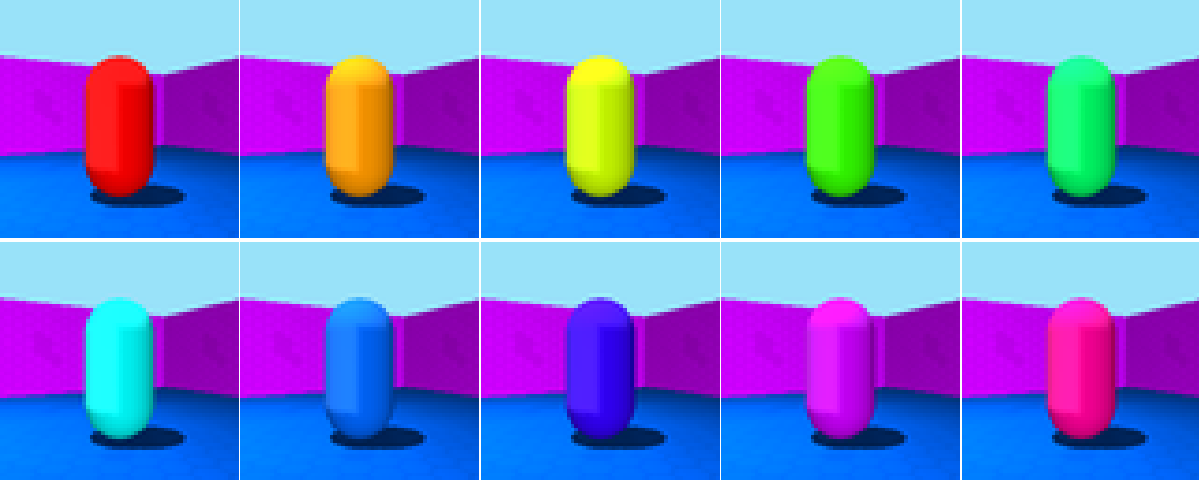

In [7]:
util.show_imgs(imgs)
pass

In [27]:
# interventions = sample_full_interventions(dataset, num_groups=50, pbar=tqdm)
# len(interventions)

In [49]:
with torch.no_grad():
    feats = model(imgs)
out = feats.cpu()
out.shape

torch.Size([10, 1280])

In [8]:
full = {}
failed = set()

In [7]:
raw = '''cspdarknet53	9038176	8192
cspresnet50	20591168	4096
cspresnext50	18520896	8192
densenet121	6953856	4096
densenet161	26472000	8832
densenet169	12484480	6656
densenet201	18092928	7680
densenetblur121d	6973088	4096
dla34	15229104	2048
dla46_c	1044400	1024
dla46x_c	811440	1024
dla60	21011632	4096
dla60_res2net	19823072	4096
dla60_res2next	16007984	4096
dla60x	16327344	4096
dla60x_c	1062832	1024
dla102	32243888	4096
dla102x	25284272	4096
dla102x2	40257200	4096
dla169	52364720	4096
dm_nfnet_f0	68416284	12288
dm_nfnet_f1	129561256	12288
dm_nfnet_f2	190706228	12288
dm_nfnet_f3	251851200	12288
dm_nfnet_f4	312996172	12288
dm_nfnet_f5	374141144	12288
dm_nfnet_f6	435286116	12288'''
full = {}
for r in raw.split('\n'):
    x,y,z = r.split('\t')
    full[x] = y,z
failed = {'adv_inception_v3'}

In [8]:
names = tqdm(list(timm.list_models(pretrained=True)))
for name in names:
    names.set_description(name)
    if name not in full and name not in failed:
        model = fig.quick_run('load-model', _type='feature-extractor', ident=name, din=(3, 64, 64),
                          pretrained=True, reshape=True, device=device, **{'feature-sel':-1,})
        try:
            with torch.no_grad():
                feats = model(imgs)
            out = feats.cpu()
        except:
            failed.add(name)
        else:
            full[name] = util.count_parameters(model), out.size(-1)
            print('{}\t{}\t{}'.format(name, *full[name]))

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/324 [00:00<?, ?it/s]

| seed: 2987316873 (by default)
| CREATING . (type=feature-extractor)
|  > feature-sel: -1
|  > features-only: True (by default)
|  > reshape: True
|  > din: (3, 64, 64)
|  > model-ID --> ident: 'dm_nfnet_f4'
|  > pretrai ned: True (by default)
|  > model-kwargs --> kwargs: {} (by default)
|  > fine-tune: True (by default)
| _print_model: False (by default)
| _load-ckpt: None (by default)
dm_nfnet_f4	312996172	12288
| seed: 517710817 (by default)
| CREATING . (type=feature-extractor)
|  > feature-sel: -1
|  > features-only: True (by default)
|  > reshape: True
|  > din: (3, 64, 64)
|  > model-ID --> ident: 'dm_nfnet_f5'
|  > pretrai ned: True (by default)
|  > model-kwargs --> kwargs: {} (by default)
|  > fine-tune: True (by default)
| _print_model: False (by default)
| _load-ckpt: None (by default)
dm_nfnet_f5	374141144	12288
| seed: 3967244137 (by default)
| CREATING . (type=feature-extractor)
|  > feature-sel: -1
|  > features-only: True (by default)
|  > reshape: True
|  > din: (3,

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-dnf-weights/dm_nfnet_f6-e0f12116.pth" to C:\Users\anwan/.cache\torch\hub\checkpoints\dm_nfnet_f6-e0f12116.pth


|  > fine-tune: True (by default)
| _print_model: False (by default)
| _load-ckpt: None (by default)
dm_nfnet_f6	435286116	12288
| seed: 2098657953 (by default)
| CREATING . (type=feature-extractor)
|  > feature-sel: -1
|  > features-only: True (by default)
|  > reshape: True
|  > din: (3, 64, 64)
|  > model-ID --> ident: 'dpn68'
|  > pretrai ned: True (by default)
|  > model-kwargs --> kwargs: {} (by default)


Downloading: "https://github.com/rwightman/pytorch-dpn-pretrained/releases/download/v0.1/dpn68-66bebafa7.pth" to C:\Users\anwan/.cache\torch\hub\checkpoints\dpn68-66bebafa7.pth


KeyboardInterrupt: 

In [10]:
full

{'cspdarknet53': (9038176, 8192),
 'cspresnet50': (20591168, 4096),
 'cspresnext50': (18520896, 8192),
 'densenet121': (6953856, 4096),
 'densenet161': (26472000, 8832),
 'densenet169': (12484480, 6656),
 'densenet201': (18092928, 7680),
 'densenetblur121d': (6973088, 4096),
 'dla34': (15229104, 2048),
 'dla46_c': (1044400, 1024),
 'dla46x_c': (811440, 1024),
 'dla60': (21011632, 4096),
 'dla60_res2net': (19823072, 4096),
 'dla60_res2next': (16007984, 4096),
 'dla60x': (16327344, 4096),
 'dla60x_c': (1062832, 1024),
 'dla102': (32243888, 4096),
 'dla102x': (25284272, 4096),
 'dla102x2': (40257200, 4096),
 'dla169': (52364720, 4096),
 'dm_nfnet_f0': (68416284, 12288),
 'dm_nfnet_f1': (129561256, 12288),
 'dm_nfnet_f2': (190706228, 12288),
 'dm_nfnet_f3': (251851200, 12288)}

In [13]:
failed

{'adv_inception_v3'}

In [9]:
for k, (x,y) in full.items():
    print(f'{k}\t{x}\t{y}')

cspdarknet53	9038176	8192
cspresnet50	20591168	4096
cspresnext50	18520896	8192
densenet121	6953856	4096
densenet161	26472000	8832
densenet169	12484480	6656
densenet201	18092928	7680
densenetblur121d	6973088	4096
dla34	15229104	2048
dla46_c	1044400	1024
dla46x_c	811440	1024
dla60	21011632	4096
dla60_res2net	19823072	4096
dla60_res2next	16007984	4096
dla60x	16327344	4096
dla60x_c	1062832	1024
dla102	32243888	4096
dla102x	25284272	4096
dla102x2	40257200	4096
dla169	52364720	4096
dm_nfnet_f0	68416284	12288
dm_nfnet_f1	129561256	12288
dm_nfnet_f2	190706228	12288
dm_nfnet_f3	251851200	12288
dm_nfnet_f4	312996172	12288
dm_nfnet_f5	374141144	12288
dm_nfnet_f6	435286116	12288


<IPython.core.display.Javascript object>


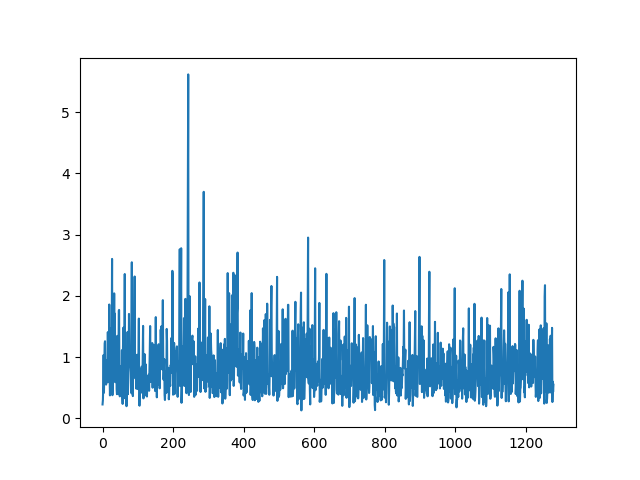

In [50]:
plt.figure()
plt.plot(out.std(0));

<IPython.core.display.Javascript object>


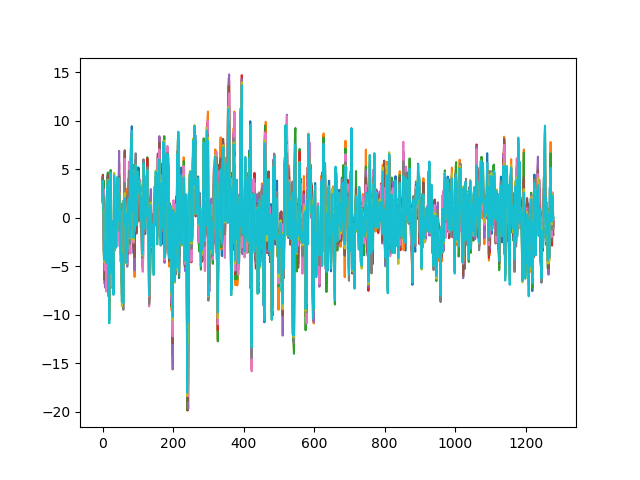

In [51]:
plt.figure()
plt.plot(out.t());

<IPython.core.display.Javascript object>


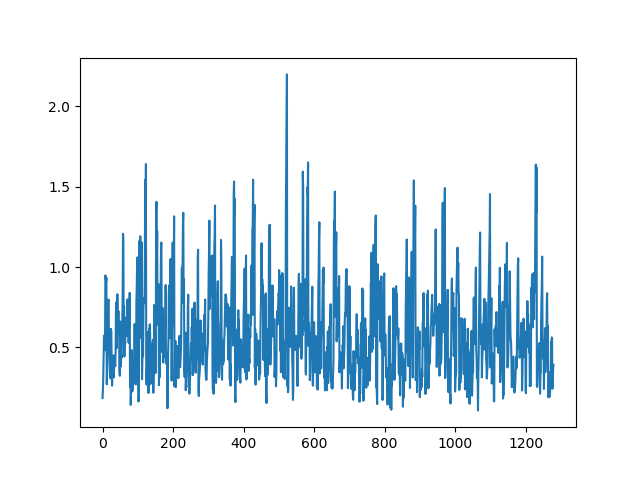

In [26]:
plt.figure()
plt.plot(out.std(0));

<IPython.core.display.Javascript object>


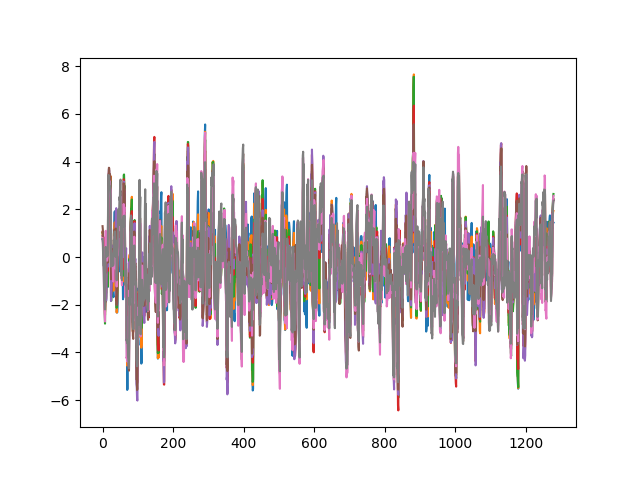

In [27]:
plt.figure()
plt.plot(out.t());

In [51]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from timm.models.resnet import ResNet, BasicBlock, default_cfgs

In [50]:
resolve_data_config('efficientnet_b0')

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875}

In [59]:
model.num_features

1280

In [55]:
resolve_data_config?
('efficientnet_b0')

'efficientnet_b0'

In [45]:

config = resolve_data_config({}, model=model)

In [46]:
config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875}

In [7]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
run_names = os.listdir(str(root))
len(run_names)

238

In [8]:
print(tabulate(enumerate(run_names)))

---  -------------------------------------------------
  0  3ds_ae0_e-c12_d-c12_210125-045343
  1  3ds_ae0_e-c12_d-c12_coord_210125-045521
  2  3ds_ae0_e-c12_d-c12_mish_210125-050038
  3  3ds_ae0_e-c12_d-c12_res-nn_210125-045937
  4  3ds_ae0_e-c12_d-c12_res_210125-045520
  5  3ds_ae0_e-c12_d-s12_210125-045438
  6  3ds_ae0_e-c12_d-s12_coord_210125-050236
  7  3ds_ae0_e-c12_d-s12_mish_210125-050335
  8  3ds_ae0_e-c12_d-s12_nosplit_210125-045438
  9  3ds_ae0_e-c12_d-s12_res-nn_210125-050336
 10  3ds_ae0_e-c12_d-s12_res_210125-050235
 11  3ds_ae0_e-c12_d-s2_210125-132645
 12  3ds_ae0_e-c12_d-s2_nosplit_210125-134343
 13  3ds_ae0_e-c12_d-s3_210125-134123
 14  3ds_ae0_e-c12_d-s3_nosplit_210125-134835
 15  3ds_ae0_e-c12_d-s4_210125-045438
 16  3ds_ae0_e-c12_d-s4_mish_210125-140253
 17  3ds_ae0_e-c12_d-s4_nosplit_210125-045440
 18  3ds_ae0_e-c12_d-s4_seed2_210125-133117
 19  3ds_ae0_e-c12_d-s6_210125-045438
 20  3ds_ae0_e-c12_d-s6_lrp0003_210125-171518
 21  3ds_ae0_e-c12_d-s6_lrp0004_210125-17

In [9]:
run_name = run_names[7] # s12 mish
# run_name = run_names[5] # s12
# run_name = random.choice(run_names)
# run_name = run_names[0] # ae conv
# run_name = run_names[27] # l12

# run_name = run_names[41]

# run_name = '3ds_vae2_e-c12_d-c12_210125-045344'
# run_name = '3ds_vae1_e-l12_d-l12_210125-045439'
# run_name = '3ds_vae16_e-c12_d-c12_210125-045345'

# run_name = short[0]


run_name

'3ds_ae0_e-c12_d-s12_mish_210125-050335'

In [10]:
load_config = fig.get_config(path=run_name, root=str(root), **{'override.device':device})
load_config.set_silent(True)
run = fig.run('load-run', load_config)

In [11]:
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'arch_type': 'strc',
 'dataset_type': '3ds',
 'dec_type': 's12',
 'enc_type': 'c12',
 'extra': 'mish',
 'model_type': 'ae',
 'size': 64}

In [12]:
# B = A.pull('dataset.batch_size', 128)
# N = 16

In [13]:
# full = run.get_results('eval')
# print(full.keys())
# # X = full['original']
# # R = full['reconstruction']
# Q = full['latent']
# if isinstance(Q, distrib.Distribution):
#     Q = Q.loc
# Q.shape

In [14]:
# diff = (X-R).abs().mean(1)
# error = diff.view(B, -1).sum(-1)
# error.shape

In [15]:
# error

In [16]:
model = run.get_model()
model.switch_to('val')
model.to(device);

Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), strid

In [228]:
# dataset = run.get_dataset()
# dataset.switch_to('val')
# len(dataset)

In [229]:
# if R is None:
#     with torch.no_grad():
#         R, Q = model(X, ret_q=True)
#         if isinstance(Q, distrib.Distribution):
#             Q = Q.loc

In [230]:
# util.show_imgs(X[:N])
# plt.suptitle('Original')
# plt.subplots_adjust(top=0.95)
# util.show_imgs(R[:N])
# plt.suptitle('Reconstructions')
# plt.subplots_adjust(top=0.95)
# pass

In [231]:
fullQ = []
total = 10000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = model.encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
fullQ.shape

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 12])

In [232]:
scales = fullQ.std(0)
# scales = None

<IPython.core.display.Javascript object>


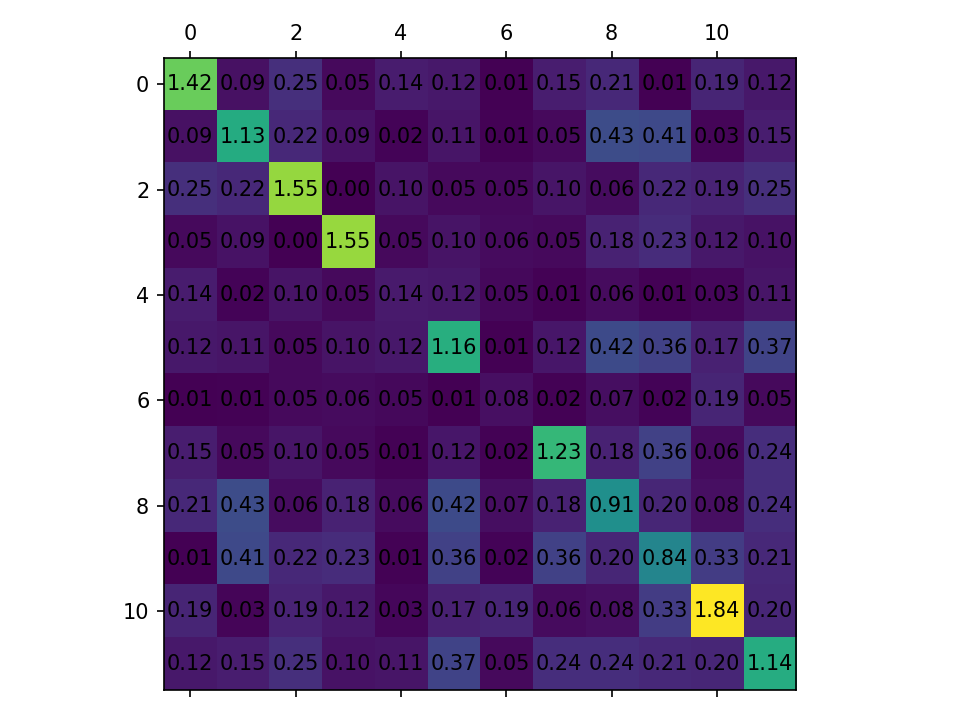

In [233]:
C = np.cov(fullQ.cpu().t().numpy())
util.plot_mat(C, val_fmt=2)
plt.tight_layout()
util.save_figure(f'{run_name}_cov', root=figure_dir)

In [234]:
R = response_mat(fullQ[:100], model.encode, model.decode, scales=scales, dist_type='rms', force_different=True)

<IPython.core.display.Javascript object>


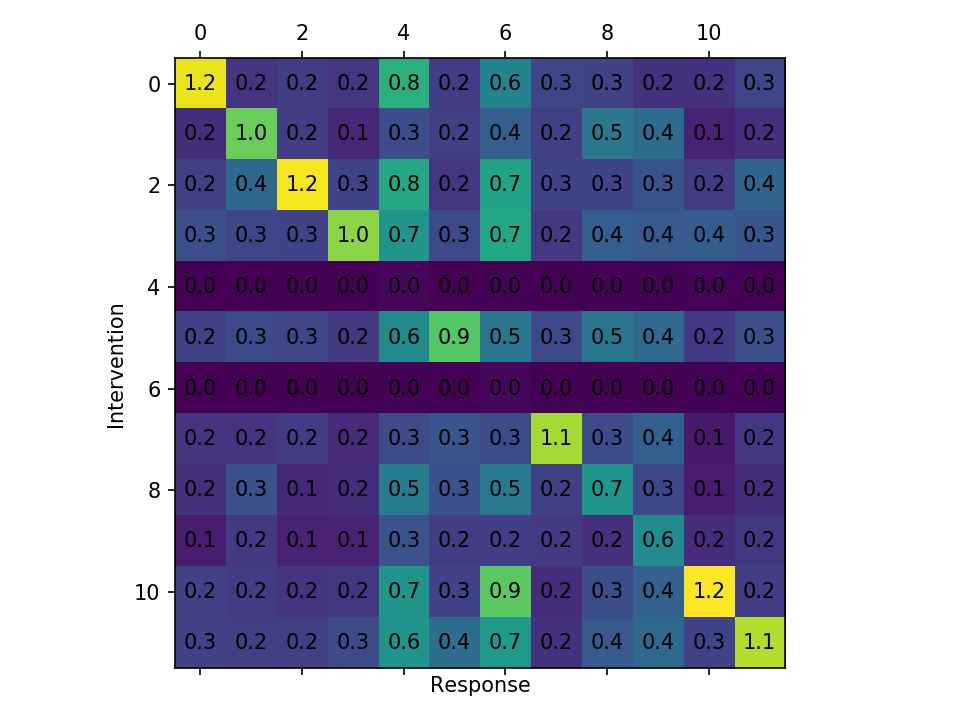

In [235]:
util.plot_mat(R, val_fmt=1) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.tight_layout()
util.save_figure(f'{run_name}_responses', root=figure_dir)

<IPython.core.display.Javascript object>


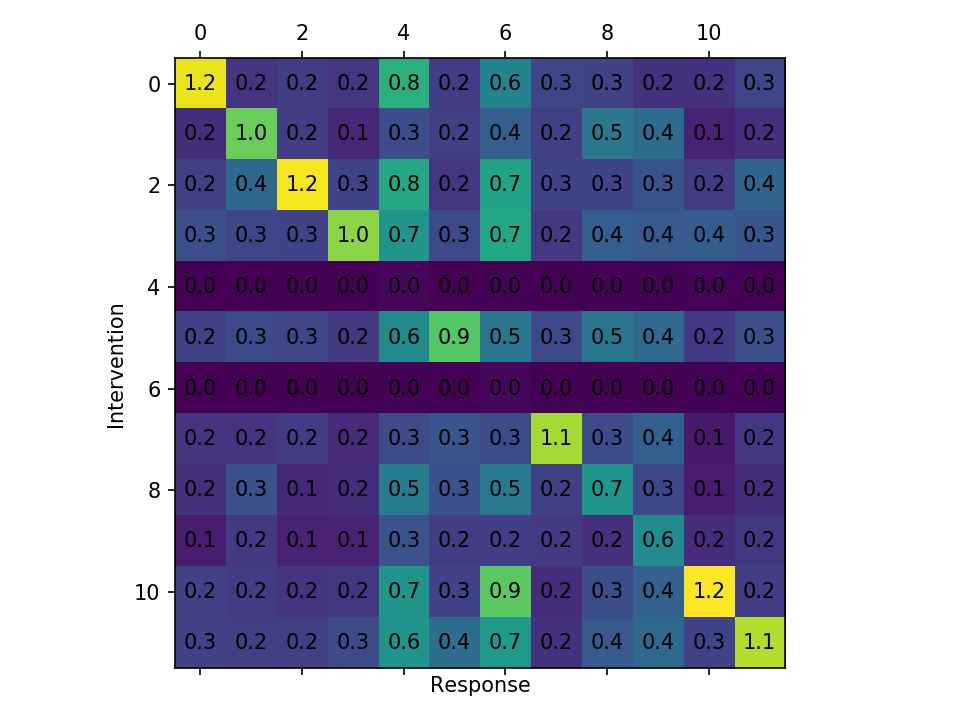

In [245]:
util.plot_mat(R, val_fmt=1) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.tight_layout()
util.save_figure(f'{run_name}_responses', root=figure_dir)

<IPython.core.display.Javascript object>


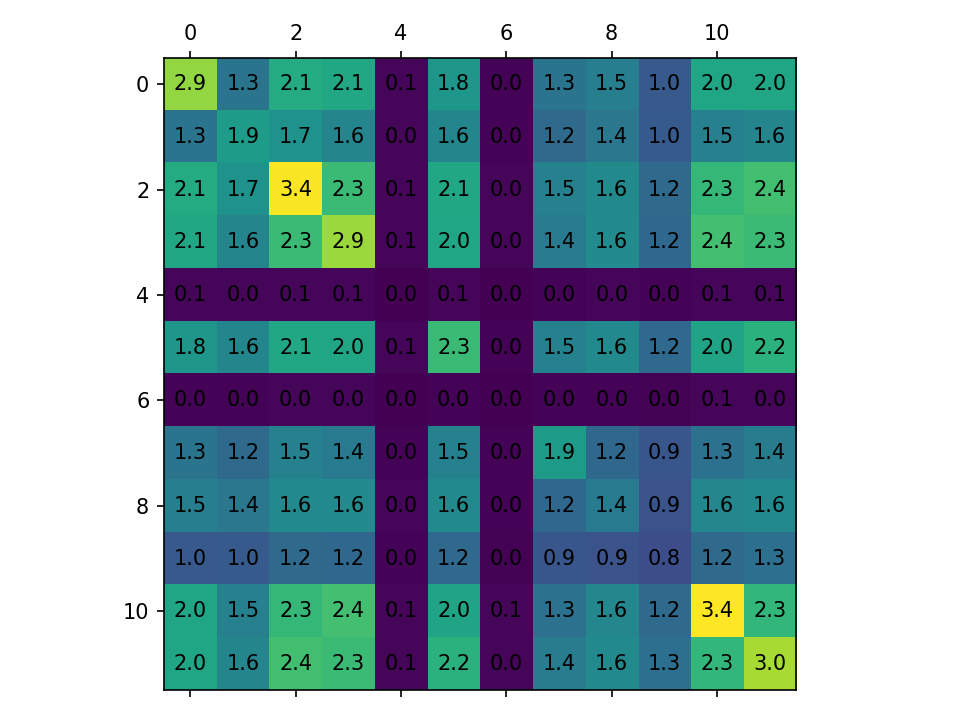

In [246]:
util.plot_mat((R @ R.t()), val_fmt=1) # interactions?
plt.tight_layout()
util.save_figure(f'{run_name}_interactions', root=figure_dir)

In [247]:
mats, lts = factor_reponses(model.encode, model.decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))
# W = mats.mean(-1).mean(1)

M = mats.min(1)[0].max(-1)[0]
# M = mats.mean(1).max(-1)[0]

mats.shape, len(lts), M.shape

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

(torch.Size([6, 50, 12, 12]), 6, torch.Size([6, 12]))

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


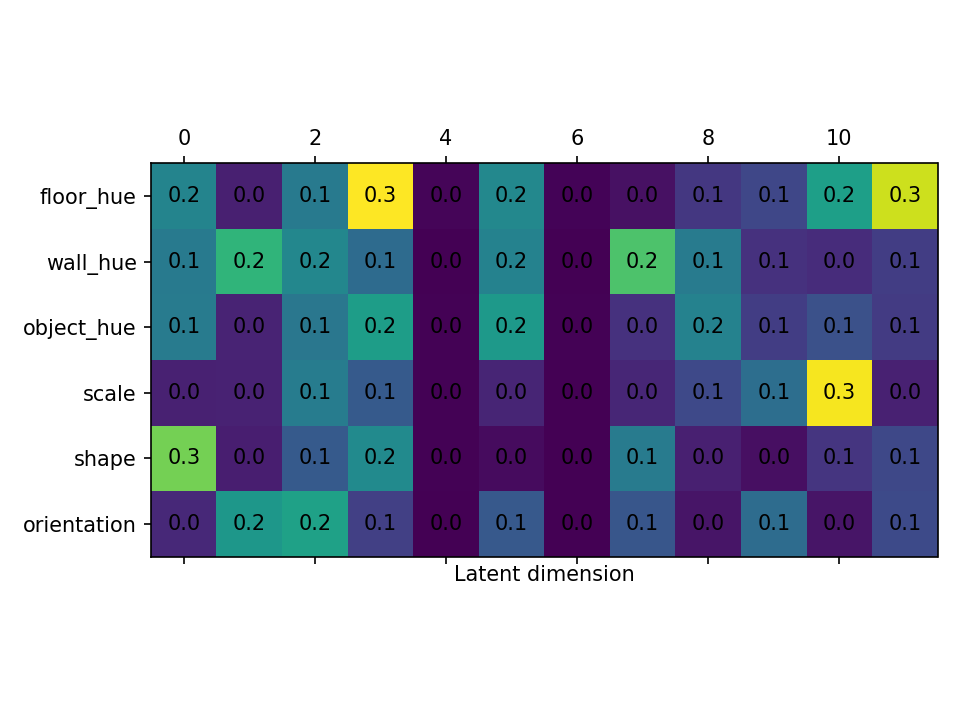

In [248]:
util.plot_mat(M, val_fmt=1)
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
pass # an intervention on which latent dimension responds the most given that the intervention can 
#      only change the given factor of variation

In [249]:
mats.shape

torch.Size([6, 50, 12, 12])

In [264]:
# util.plot_mat(W, val_fmt=1);

In [252]:
tot = M.max(0)[0].sum() / M.sum()
# tot = M.sum(0).sub(wt)#.div(wt)#.sum().div(12)
# util.plot_mat(tot, val_fmt=1);
tot

tensor(0.5065, device='cuda:0')

In [255]:
# best = M.clamp(max=1)
# util.plot_mat(best.max(1)[0].unsqueeze(0), val_fmt=1);

In [256]:
# best = M.clamp(max=1)
# util.plot_mat(best.max(0)[0].unsqueeze(0), val_fmt=1);

<IPython.core.display.Javascript object>


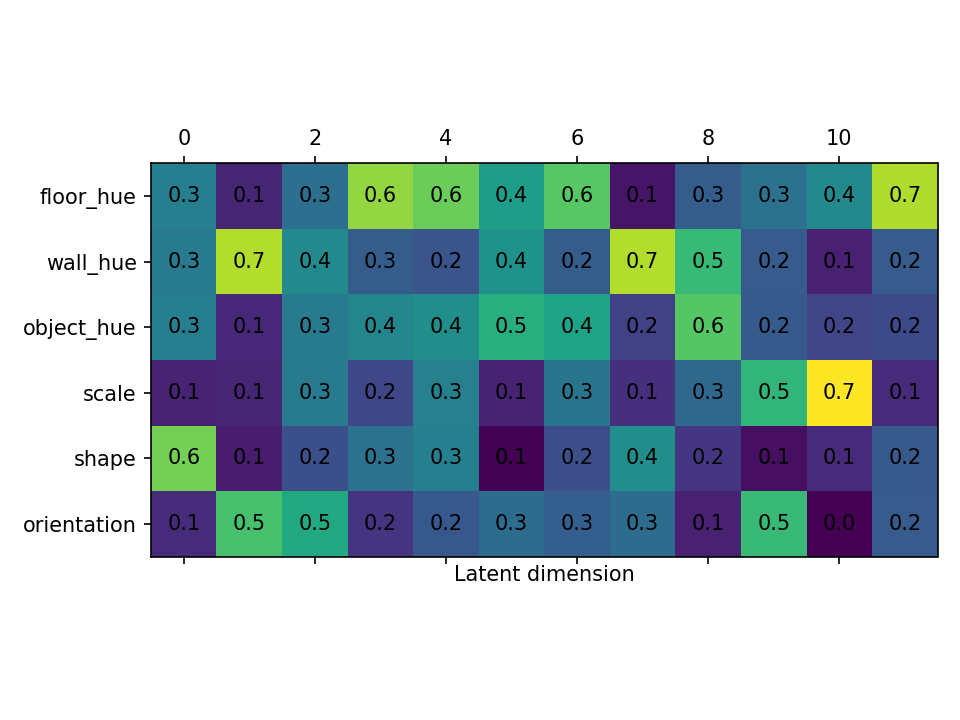

In [267]:
changes = torch.stack([(x - x.mean(1,keepdim=True)).pow(2).sqrt().div(scales).mean(1) for x in lts]).mean(1)
util.plot_mat(changes, val_fmt=1);
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
util.save_figure(f'{run_name}_factor-latent-changes', root=figure_dir)

In [254]:
# util.plot_mat(mats.sum(2).mean(1), val_fmt=1)
# plt.yticks(range(len(factors)), factors)
# plt.xlabel('Latent dimension')
# plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
# pass # which latent dimension responds the most to interventions in the given factor of variation

In [29]:
def ae_cycle(q):
    with torch.no_grad():
        im = model.decode(q.to(device))
        q = model.encode(im)
    return im.cpu(), q.cpu()

def get_loss(im, orig):
    return F.binary_cross_entropy(im,orig)

In [130]:
batch = dataset.get_batch(shuffle=True)
x, y = batch
x.shape, y.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64, 6]))

In [131]:
Im = x.cpu()
with torch.no_grad():
    Q = model.encode(Im.to(device)).cpu()
q.shape

torch.Size([64, 12])

<IPython.core.display.Javascript object>


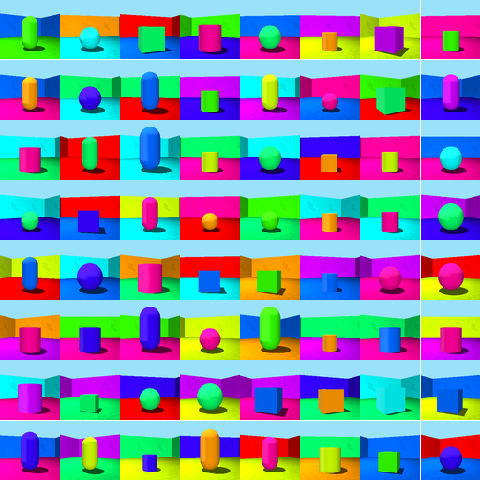

In [132]:
util.show_imgs(Im);

In [140]:
N = 100

In [141]:
q = Q
prev = Im
Imgs, Qs = [Im], [Q]
for _ in tqdm(range(N)):
    im, q = ae_cycle(q)
    Imgs.append(im)
    Qs.append(q)
Imgs = torch.stack(Imgs)
Qs = torch.stack(Qs)/Q.std(0, keepdim=True).unsqueeze(0)
Imgs.shape, Qs.shape

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


(torch.Size([101, 64, 3, 64, 64]), torch.Size([101, 64, 12]))

In [142]:
L1 = torch.stack([get_loss(i1, i2) for i1, i2 in zip(Imgs[1:], Imgs[:-1])])
D1 = Qs[1:].sub(Qs[:-1]).pow(2).view(N, -1).sum(-1)
L1.shape, D1.shape

(torch.Size([100]), torch.Size([100]))

In [143]:
L = torch.stack([get_loss(i1, i2) for i1, i2 in zip(Imgs[1:], (len(Imgs)-1)*[Imgs[0]])])
D = Qs[1:].sub(Qs[:1]).pow(2).view(N, -1).sum(-1)
L.shape, D.shape

(torch.Size([100]), torch.Size([100]))

<IPython.core.display.Javascript object>


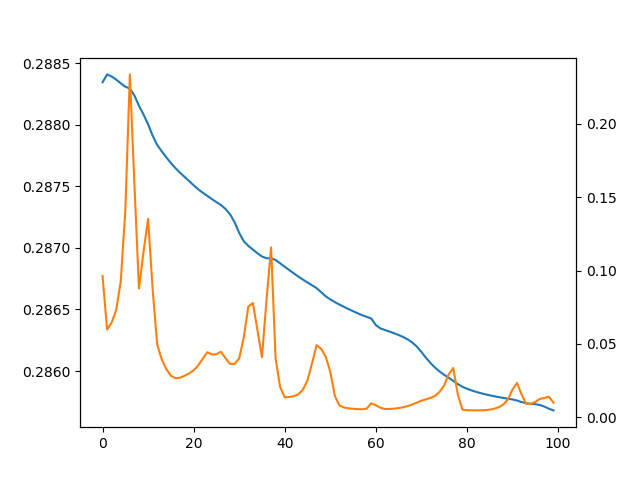

In [144]:
plt.figure()
plt.plot(L1, c='C0');
plt.twinx()
plt.plot(D1, c='C1');

<IPython.core.display.Javascript object>


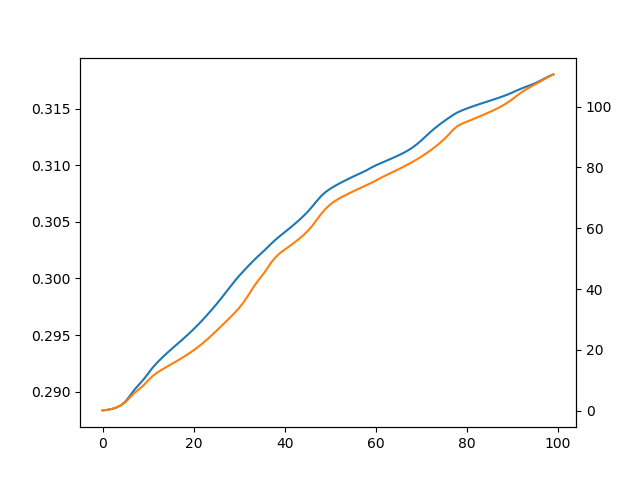

In [146]:
plt.figure()
plt.plot(L, c='C0');
plt.twinx()
plt.plot(D, c='C1');

<IPython.core.display.Javascript object>


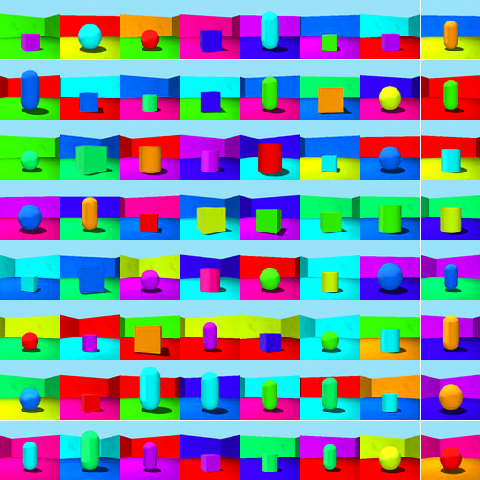

(<Figure size 480x480 with 64 Axes>, <numpy.flatiter at 0x27ea75c9630>)

In [117]:
util.show_imgs(Imgs[10])

<IPython.core.display.Javascript object>


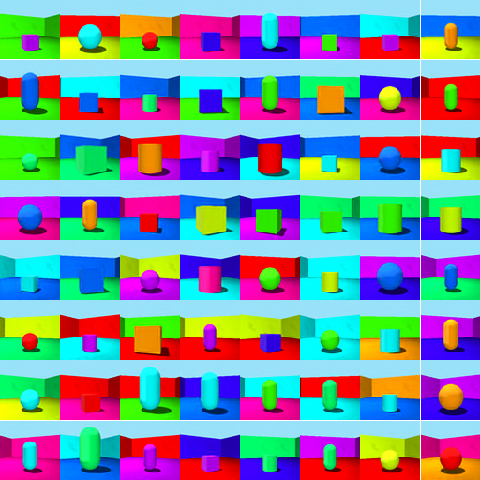

(<Figure size 480x480 with 64 Axes>, <numpy.flatiter at 0x27ea75ca0c0>)

In [124]:
util.show_imgs(Imgs[50])

<IPython.core.display.Javascript object>


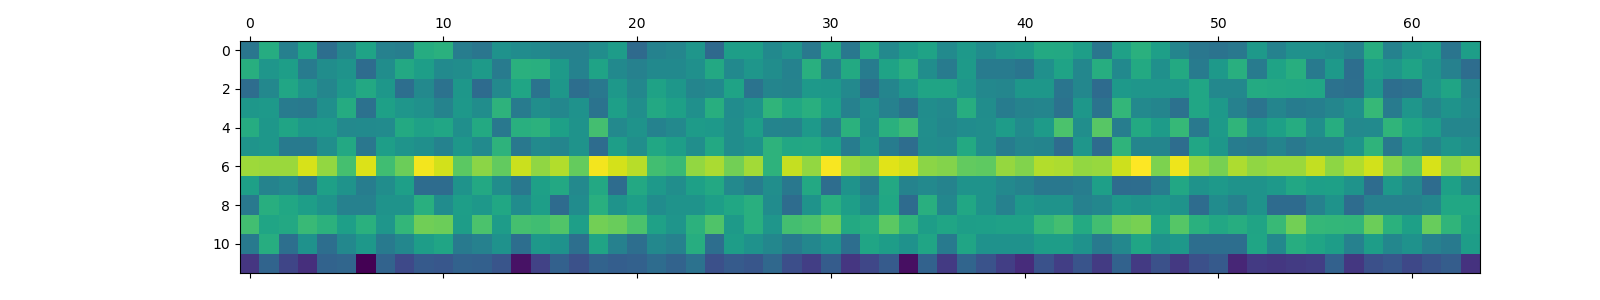

In [148]:
plt.matshow(Qs[0].t())

<IPython.core.display.Javascript object>


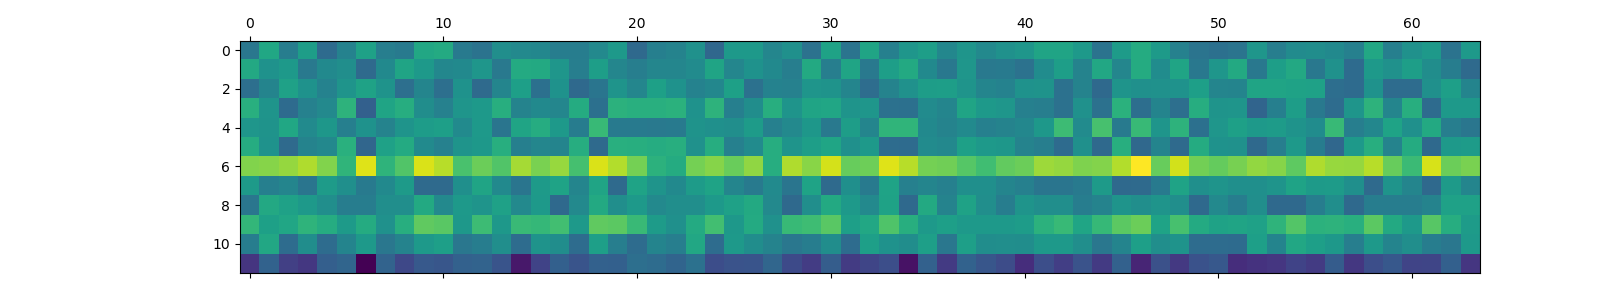

In [149]:
plt.matshow(Qs[-1].t())

<IPython.core.display.Javascript object>


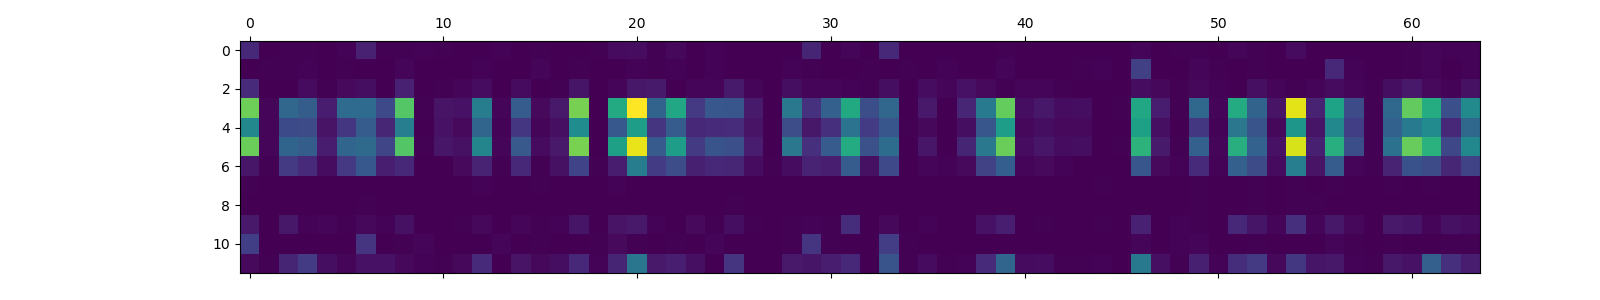

In [150]:
plt.matshow(Qs[-1].sub(Qs[0]).abs().t())